In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

##Load DataSet


In [ ]:
train_data_path = "/content/drive/MyDrive/Covid19_Chest-Xray/train-20220418T102302Z-001.zip (Unzipped Files)/train"
test_data_path = "/content/drive/MyDrive/Covid19_Chest-Xray/test-20220418T102303Z-001.zip (Unzipped Files)/test"
train_data_path

'/content/drive/MyDrive/Covid19_Chest-Xray/train-20220418T102302Z-001.zip (Unzipped Files)/train'

## Data Augmentation 

In [ ]:
image_size = 120

img_transform = transforms.Compose([
                                    transforms.Resize((image_size , image_size)) , 
                                    transforms.RandomVerticalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.485 , 0.456 , 0.406] , std = [0.229 ,0.224,0.225])
])

## ImageFolder & Data Loader


In [ ]:
train_data = ImageFolder(root = train_data_path , transform=img_transform)
testing_data = ImageFolder(root = test_data_path , transform=img_transform)

In [ ]:
len(train_data) , len(testing_data)

(251, 66)

In [ ]:
print(train_data.classes)
print(train_data.class_to_idx)
print(testing_data.class_to_idx)

['Covid', 'Normal', 'Viral Pneumonia']
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [ ]:
for img , label in train_data:
  print(img.shape)
  break

torch.Size([3, 120, 120])


In [ ]:
test_data, val_data = random_split(testing_data,[16,50])

In [ ]:
train_loader = DataLoader(dataset=train_data , batch_size=16 , shuffle=True)
val_loader = DataLoader(dataset=test_data , batch_size=16 , shuffle=False)

In [ ]:
for img , label in train_loader:
  print(img.shape)
  break

torch.Size([16, 3, 120, 120])


In [ ]:
val_data


## Data Visualization


In [ ]:
def img_show(data):
  for img , label in data:
    plt.figure(figsize=(10 , 7))
    plt.imshow(make_grid(img , n_rows = 5 ).permute(1,2,0))
    plt.show()
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


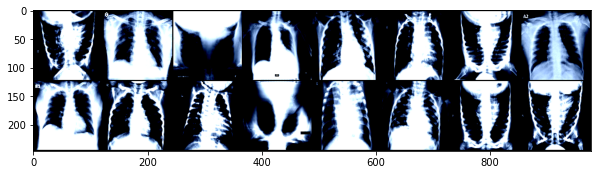

In [ ]:
img_show(val_loader)

## Creating Model 

In [ ]:
input_size = image_size*image_size*3  # flatten array (120*120*3)
hidden_size = 64
num_output = 3

class ANN(nn.Module):
  def __init__(self):
    super(ANN , self).__init__()
    self.fc1 = nn.Linear(in_features=input_size , out_features=hidden_size)
    self.fc2 = nn.Linear(in_features=hidden_size , out_features=3)
    # self.fc3 = nn.Linear(in_features=50 , out_features=3)
    self.reLu = nn.ReLU()
  def forward(self , image):
    out = image.view(-1 , image_size*image_size*3)
    out = self.reLu(self.fc1(out))
    out = self.fc2(out)
    # out = self.reLu(self.fc3(out))
    return out
  

In [ ]:
model = ANN()
model.to(device)
model.parameters  

<bound method Module.parameters of ANN(
  (fc1): Linear(in_features=43200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (reLu): ReLU()
)>

In [ ]:
def train_model(loss_fn , optimizer, epochs = 20):
  training_acc = []
  training_loss = []
  testing_acc = []
  testing_loss = []
  for epoch in range(epochs):
    train_acc = 0.0 
    train_loss = 0.0

    model.train()

    for images , labels in train_loader:

      images = images.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      output = model(images)
      loss = loss_fn(output , labels)
      loss.backward()
      optimizer.step()
      prediction = torch.argmax(output , 1)
      train_acc += (prediction == labels).sum().item()
      train_loss += loss.item()
    training_acc.append(train_acc/len(train_data))
    training_loss.append(train_loss/len(train_loader))


    test_acc = 0.0 
    test_loss = 0.0

    model.eval()
    with torch.no_grad():
      for images , labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
      
        output = model(images)
        loss = loss_fun(output , labels)

        prediction = torch.argmax(output , 1)
        test_acc += (prediction == labels).sum().item()
        test_loss += loss.item()
      testing_acc .append(test_acc/len(val_data))
      testing_loss.append(test_loss/len(val_loader))

    print(f"Epochs:{epoch+1}, Training Accuracy:{train_acc/len(train_data):.2f}, Training Loss:{train_loss/len(train_loader):.2f}, Validation Accuracy:{test_acc/len(val_data):2f}, Validation Loss:{test_loss/len(val_loader):.2f}")
  plt.title("Accuracy Vs Epochs")
  plt.plot(range(20), training_acc, label ="Training Accuracy")
  plt.plot(range(epochs), testing_acc, label = "Validation Accuracy")
  plt.legend()
  plt.xlabel("Accuracy")
  plt.ylabel("Epochs")
  plt.show()
  plt.title("Loss Vs Epochs")
  plt.plot(range(epochs), training_loss, label ="Training Loss")
  plt.plot(range(epochs), testing_loss, label = "Validation Loss")
  plt.legend()
  plt.xlabel("Accuracy")
  plt.ylabel("Epochs")
  plt.show()

Epochs:1, Training Accuracy:0.73, Training Loss:0.69, Validation Accuracy:0.180000, Validation Loss:0.84
Epochs:2, Training Accuracy:0.82, Training Loss:0.45, Validation Accuracy:0.180000, Validation Loss:0.81
Epochs:3, Training Accuracy:0.90, Training Loss:0.35, Validation Accuracy:0.200000, Validation Loss:0.55
Epochs:4, Training Accuracy:0.92, Training Loss:0.27, Validation Accuracy:0.220000, Validation Loss:0.65
Epochs:5, Training Accuracy:0.94, Training Loss:0.25, Validation Accuracy:0.220000, Validation Loss:0.65
Epochs:6, Training Accuracy:0.93, Training Loss:0.23, Validation Accuracy:0.180000, Validation Loss:0.60
Epochs:7, Training Accuracy:0.93, Training Loss:0.21, Validation Accuracy:0.200000, Validation Loss:0.85
Epochs:8, Training Accuracy:0.94, Training Loss:0.19, Validation Accuracy:0.280000, Validation Loss:0.54
Epochs:9, Training Accuracy:0.94, Training Loss:0.19, Validation Accuracy:0.240000, Validation Loss:0.60
Epochs:10, Training Accuracy:0.94, Training Loss:0.18, 

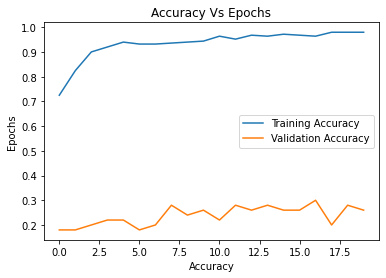

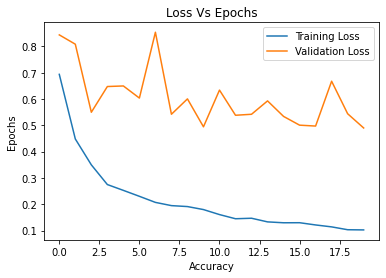

In [ ]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters() , lr = 0.001)
train_model(loss_fun , optimizer)

In [ ]:
def predict_img(img , model):
  img = img.to(device)
  model = model.to(device)
  x = img.unsqueeze(0)
  y = model(x)
  pred = torch.argmax(y , 1)
  return testing_data.classes[pred]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: Normal Predicted Label: Normal


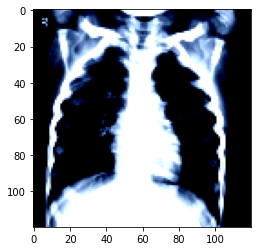

In [ ]:
img, label = test_data[9]
plt.imshow(img.permute(1,2,0))
print("Actual Label:", testing_data.classes[label], 
       "Predicted Label:", predict_img(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: Normal Predicted Label: Viral Pneumonia


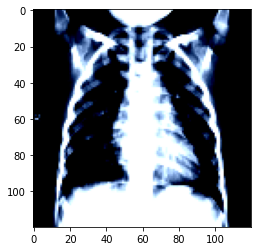

In [ ]:
img, label = test_data[15]
plt.imshow(img.permute(1,2,0))
print("Actual Label:", testing_data.classes[label], 
       "Predicted Label:", predict_img(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: Viral Pneumonia Predicted Label: Viral Pneumonia


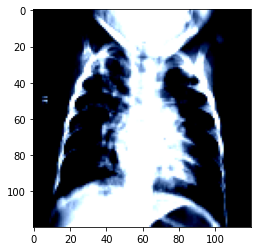

In [ ]:
img, label = test_data[0]
plt.imshow(img.permute(1,2,0))
print("Actual Label:", testing_data.classes[label], 
       "Predicted Label:", predict_img(img, model))